<a href="https://colab.research.google.com/github/tomosantos/dio-ml-projects/blob/main/notebooks/image_similarity_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Similar Product Recommendations
> A tutorial on building a recommender system that will find similar looking products

- toc: true
- badges: true
- comments: true
- categories: [similarity vision]
- image:

In [3]:
pip install -q tensorflow==2.15.0 tensorflow-hub keras==2.15.0

In [4]:
#hide
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#hide
#{"username":"<your kaggle username>","key":"<your kaggle api key>"}
%%writefile kaggle.json


Writing kaggle.json


In [6]:
#hide
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=3a72bea83646e3951e6668c49660442941879ce6ba084d81393f50c80e1e71aa
  Stored in directory: /root/.cache/pip/wheels/9f/af/22/bf406f913dc7506a485e60dce8143741abd0a92a19337d83a3
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


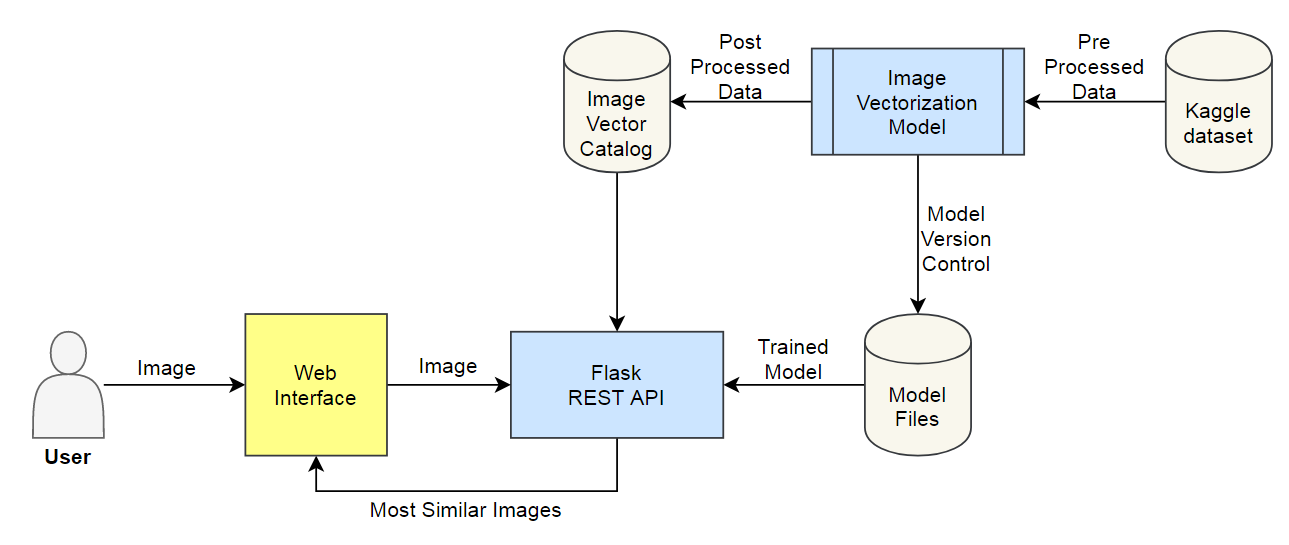

### Choice of variables

- Image Encoder: Any pre-trained image classification model can be selected. These models are commonly known as encoders because their job is to encode an image into a feature vector. In our case, we analyzed four encoders named 1) MobileNet, 2) EfficientNet, 3) ResNet and 4) [BiT](https://tfhub.dev/google/bit/m-r152x4/1). After some basic research, we decided to select BiT model because of its performance. I selected the BiT-M-50x3 variant of model which is of size 748 MB. More details about this architecture can be found on the official page [here](https://tfhub.dev/google/bit/m-r50x3/1).
- Vector Similarity System: Images are represented in a fixed-length feature vector format. For the given input vector, we need to find the TopK most similar vectors, keeping the memory efficiency and real-time retrival objective in mind. We explored the most popular techniques and listed down five of them: Annoy, Cosine distance, L1 distance, Locally Sensitive Hashing (LSH) and Image Deep Ranking. We selected Annoy because of its fast and efficient nature. More details about Annoy can be found on the official page [here](https://github.com/spotify/annoy).
- Dataset: This system is able to handle all kind of image dataset. Only the basic preprocessing (in step 1) would need some modifications depending on the dataset. We chose [Fashion Product Images (Small)](https://www.kaggle.com/bhaskar2443053/fashion-small?). Other examples can be [Food-11 image dataset](https://www.kaggle.com/trolukovich/food11-image-dataset?), and [Caltech 256 Image Dataset](https://www.kaggle.com/jessicali9530/caltech256?).

### Step 1: Data Acquisition

Download the raw image dataset into a directory. Categorize these images into their respective category directories. Make sure that images are of the same type, JPEG recommended. We will also process the metadata and store it in a serialized file, CSV recommended.

In [7]:
#hide-output
# downloading raw images from kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip -q fashion-product-images-small.zip

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
100% 564M/565M [00:31<00:00, 19.8MB/s]
100% 565M/565M [00:31<00:00, 19.1MB/s]


In [8]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [03:41<00:00, 200.98it/s]

Moved 44441 images.


### Step 2: Encoder Fine-tuning [optional]

Download the pre-trained image model and add two additional layers on top of that: the first layer is a feature vector layer and the second layer is the classification layer. We will only train these 2 layers on our data and after training, we will select the feature vector layer as the output of our fine-tuned encoder. After fine-tuning the model, we will save the feature extractor for later use.

In [9]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.16.1
GPU is available


In [10]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [11]:
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)


In [12]:
#hide
data_dir = '/content/Fashion_data/categories'

In [13]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.


In [14]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(N_FEATURES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 212748999 (811.57 MB)
Trainable params: 1574919 (6.01 MB)
Non-trainable params: 211174080 (805.57 MB)
_____________

In [15]:
# Define optimiser and loss
lr = 0.003 * BATCH_SIZE / 512
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [16]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
1111/1111 [==============================] - 1248s 1s/step - loss: 0.2368 - accuracy: 0.9670 - val_loss: 0.1323 - val_accuracy: 0.9879
Epoch 2/5
1111/1111 [==============================] - 1236s 1s/step - loss: 0.1823 - accuracy: 0.9747 - val_loss: 0.1323 - val_accuracy: 0.9879
Epoch 3/5
1111/1111 [==============================] - 1216s 1s/step - loss: 0.1799 - accuracy: 0.9767 - val_loss: 0.1322 - val_accuracy: 0.9879
Epoch 4/5
1111/1111 [==============================] - 1237s 1s/step - loss: 0.1853 - accuracy: 0.9754 - val_loss: 0.1322 - val_accuracy: 0.9879
Epoch 5/5
1111/1111 [==============================] - 1237s 1s/step - loss: 0.1822 - accuracy: 0.9757 - val_loss: 0.1321 - val_accuracy: 0.9877


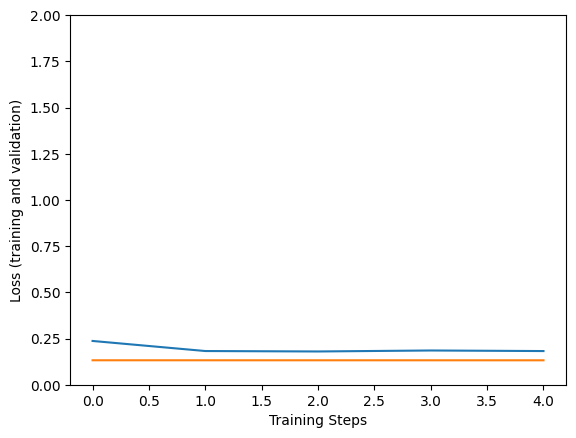

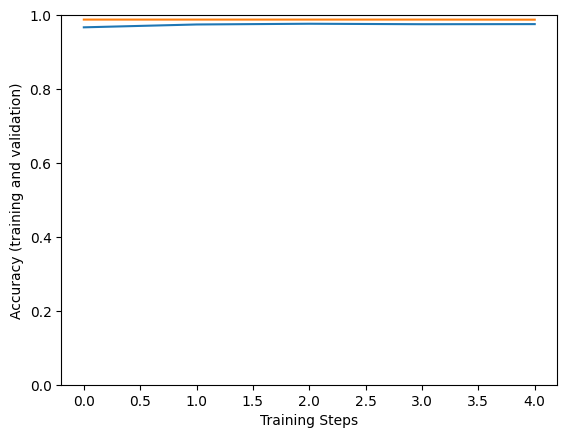

In [17]:
#hide
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [18]:
if not os.path.exists('/content/drive/MyDrive/ImgSim/'):
    os.mkdir('/content/drive/MyDrive/ImgSim/')

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/content/drive/MyDrive/ImgSim/bit_feature_extractor', save_format='tf')

saved_model_path = '/content/drive/MyDrive/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

### Step 3: Image Vectorization
Now, we will use the encoder (prepared in step 2) to encode the images (prepared in step 1). We will save feature vector of each image as an array in a directory. After processing, we will save these embeddings for later use.

In [19]:
#hide
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

In [20]:
img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [21]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [22]:
#hide-output
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model('/content/drive/MyDrive/ImgSim/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1"
  module = hub.load(module_handle)

In [23]:
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [24]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 5000/5000 [09:09<00:00,  9.09it/s]


### Step 4: Metadata and Indexing

We will assign a unique id to each image and create dictionaries to locate information of this image: 1) Image id to Image name dictionary, 2) Image id to image feature vector dictionary, and 3) (optional) Image id to metadata product id dictionary. We will also create an image id to image feature vector indexing. Then we will save these dictionaries and index object for later use.

In [25]:
#hide
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


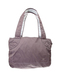

In [26]:
test_img = '/content/Fashion_data/categories/Accessories/1941.jpg'
dispImage(test_img)

In [27]:
#hide-output
# styles = pd.read_csv('/content/styles.csv', error_bad_lines=False)
styles = pd.read_csv('/content/styles.csv', on_bad_lines='skip')
styles['id'] = styles['id'].astype('str')
# styles.to_csv(root_path+'/styles.csv', index=False)
styles.to_csv('/styles.csv', index=False)

In [28]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [29]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors
allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [30]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

5000it [00:38, 130.51it/s]


In [31]:
#hide-output
t.build(trees)
t.save('t.ann')

True

In [32]:
#hide
file_path = '/content/drive/MyDrive/ImgSim/'

In [33]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

## Step 5: Local Testing

We will load a random image and find top-K most similar images.

In [34]:
#hide
from PIL import Image
import matplotlib.image as mpimg

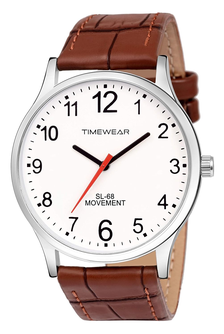

In [35]:
img_addr = 'https://images-na.ssl-images-amazon.com/images/I/81%2Bd6eSA0eL._UL1500_.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.Resampling.LANCZOS)
img

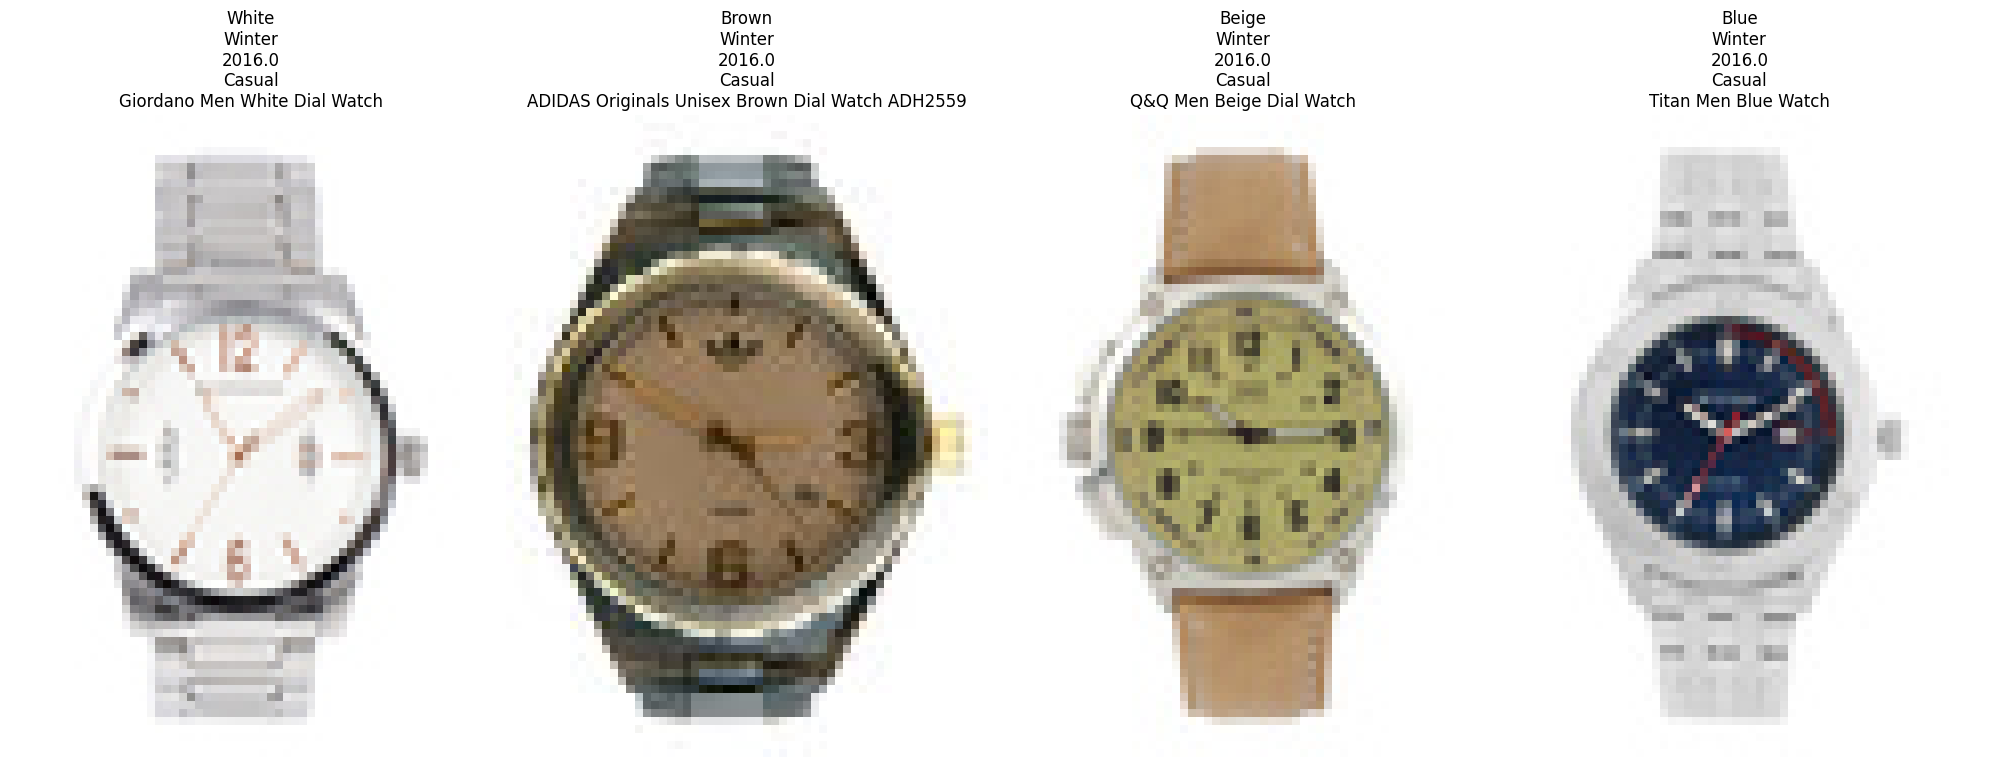

In [36]:
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()